In [81]:
import numpy as np

path = '/home/ornela/PYTHON/'

read  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/datos/scannapieco/curva_roja.dat')
R_red = read[:,0]
red   = read[:,1]

read  = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/datos/scannapieco/curva_azul.dat')
R_blue = read[:,0]
blue   = read[:,1]

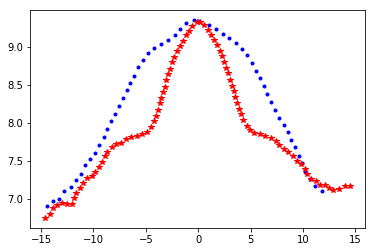

In [83]:
import matplotlib.pyplot as plt

plt.plot(R_blue,blue,'.b')
plt.plot(R_red,red,'*r')

In [84]:
import scipy.interpolate as sint

finterp_red = sint.interp1d(R_red,red,fill_value="extrapolate")
finterp_blue = sint.interp1d(R_blue,blue,fill_value="extrapolate")
point = np.linspace(-15,15,300)

RED = finterp_red(point)
BLUE = finterp_blue(point)

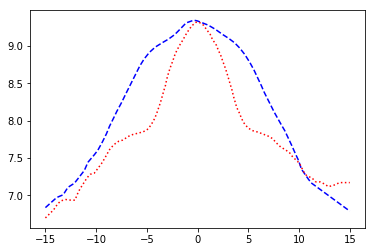

In [85]:
plt.plot(point, BLUE, '--b')
plt.plot(point, RED, ':r')

4.665551839464882


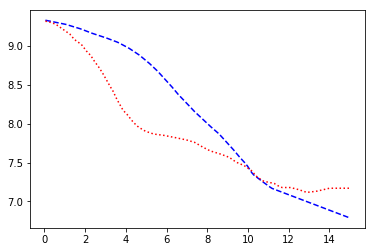

In [93]:
mask1, = np.where(point>0)
diff = BLUE[mask1]-RED[mask1]

plt.plot(point[mask1], BLUE[mask1], '--b')
plt.plot(point[mask1], RED[mask1], ':r')

print(point[mask1][diff.argmax()])

(0.9329903691316721, 0.046649518456583605)
9.806809969580343


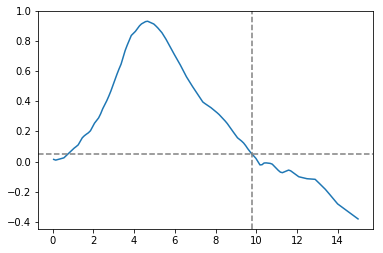

In [94]:

cut = diff.max()*0.05
print(diff.max(),cut)
finterp = sint.interp1d(point[mask1],diff,fill_value="extrapolate")
point2 = np.linspace(point[mask1][diff.argmax()],15,200)

resta = finterp(point2) - cut
mask, = np.where(resta < 0.)

lbar4 = point2[mask][0]
print (lbar4)

plt.plot(point[mask1],diff)
plt.axvline(x=lbar4,ls='--',color='gray')
plt.axhline(y=cut,ls='--',color='gray')

-4.866220735785953


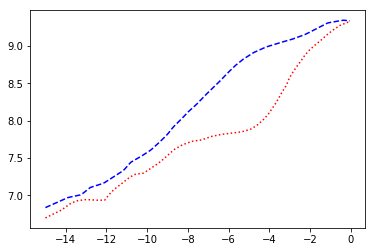

In [96]:
mask2, = np.where(point<0)
diff = BLUE[mask2]-RED[mask2]

plt.plot(point[mask2], BLUE[mask2], '--b')
plt.plot(point[mask2], RED[mask2], ':r')

print(point[mask2][diff.argmax()])

(1.0031412578966918, 0.0501570628948346)


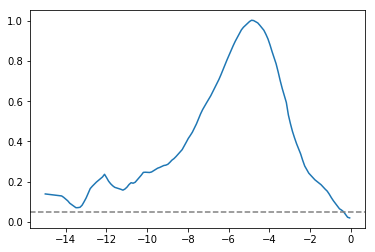

In [99]:
cut = diff.max()*0.05
print(diff.max(),cut)

finterp = sint.interp1d(point[mask2],diff,fill_value="extrapolate")
point2 = np.linspace(point[mask2][diff.argmax()],-15,200)

resta = finterp(point2) - cut
mask, = np.where(resta < 0.)

lbar4 = point2[mask]
if len(lbar4)==0:
    pass
else:
    print (lbar4[0])

plt.plot(point[mask2],diff)
# plt.axvline(x=lbar4,ls='--',color='gray')
plt.axhline(y=cut,ls='--',color='gray')

### Para Gasoline

In [100]:
import numpy as np
#----------------------------------------------------------------------
# Densidad superficial de masa con bines equiespaciados (en x o y)
#----------------------------------------------------------------------
def surf_density_x(x,y,m,nbin,nmin,nmax):
    
    mass, xedges, yedges = np.histogram2d(x, y, nbin, [[nmin,nmax],[nmin,nmax]], weights=m)
    
#     nodos  = np.concatenate([-nodos_[::-1],nodos_])
    
    sigmax = np.zeros(nbin)
    sigmay = np.zeros(nbin)
    
    widthx = np.diff(xedges)
    widthy = np.diff(yedges)
    
    medx   = xedges[:-1] + widthx/2.
    medy   = yedges[:-1] + widthy/2.
    
    middle = nbin//2
    
    for i in range(nbin):
        areax     = widthx[i]*widthy[middle]
        sigmax[i] = mass[i,middle]/areax

        areay     = widthy[i]*widthx[middle]
        sigmay[i] = mass[middle,i]/areay
    
    return sigmax, sigmay, medx, medy

lbar_perf = 1.1675579535840739
lbar_perf_mod =  1.0338681147556112
lbar_perf = 3.0837789767920367
lbar_perf_mod =  1.8805704273358739
lbar_perf = 3.494751477482343
lbar_perf_mod =  3.4571202644194017


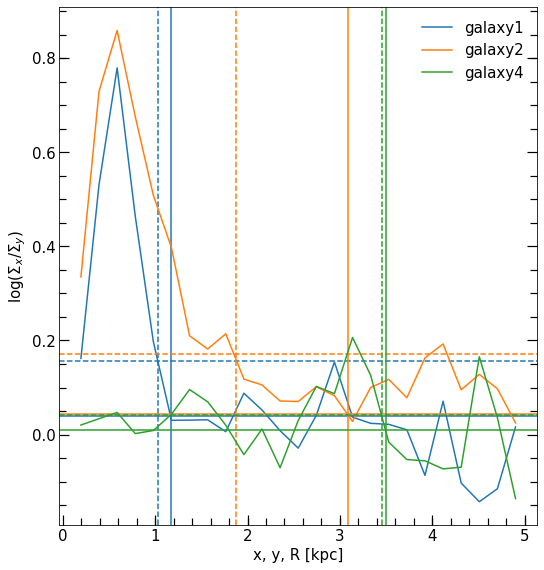

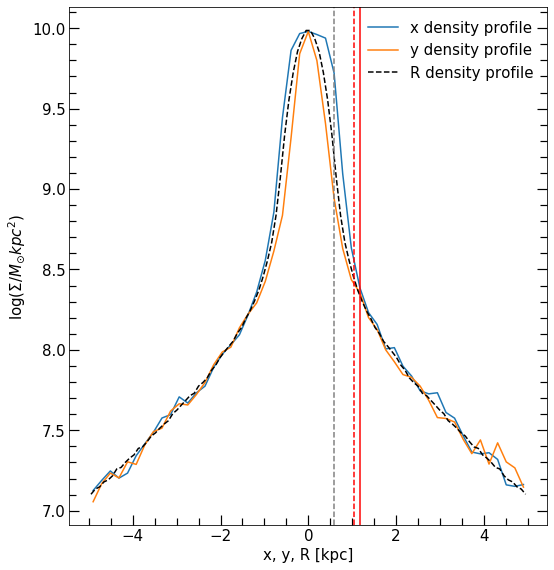

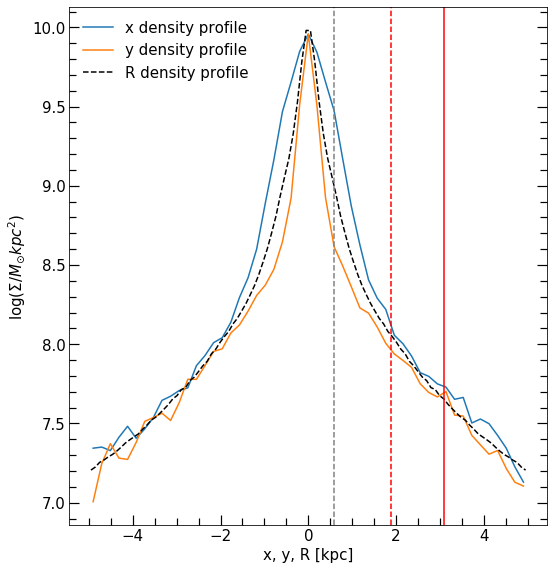

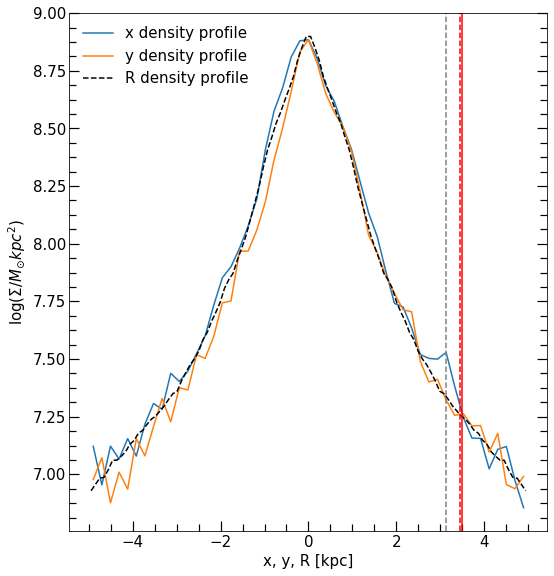

In [104]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

colores = ('r','tab:blue','tab:orange','r','tab:green')
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
figs.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

# for j in range(len(snapshot)-1,32,-1):
j=0

halos = (1,2,4)

for i in halos:
# i=1
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte],nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte],nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx>0)]) - np.log10(sigmay[np.where(medx>0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx>0)],diff,fill_value="extrapolate")
    point = np.linspace(medx[np.where(medx>0)][diff.argmax()],5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
#     vector=('M31','MW','..','M33')
#     path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
#     archivo = np.ndarray
#     np.savetxt(archivo,'')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
    ax.plot(medx, np.log10(sigmax), '-',color='tab:blue', label='x density profile')    
    ax.plot(medy, np.log10(sigmay), '-',color='tab:orange', label='y density profile')    
    ax.plot(RR, np.log10(Rpf), color='k', ls='--', label='R density profile')
    #     ax.plot(medx, diff)
    ax.axvline(x=lbar4,color='r')
    ax.axvline(x=lbar6,color='r',ls='--')
    ax.axvline(x=medx[np.where(medx>0)][arg], color='gray',ls='--')
    # ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
    ax.set_xlabel('x, y, R [kpc]',fontsize=15)
    ax.legend(fontsize=15,frameon=False)


    axs.plot(medx[np.where(medx>0)], diff, '-', label='galaxy'+str('%s'%i))
    axs.axvline(x=lbar4,ls='-',color=colores[i])
    axs.axhline(y=cut,ls='-',color=colores[i])
    axs.axvline(x=lbar6,ls='--',color=colores[i])
    axs.axhline(y=cut2,ls='--',color=colores[i])
    


axs.minorticks_on()
axs.tick_params( labelsize=15)
axs.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
axs.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
axs.set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=15)
axs.set_xlabel('x, y, R [kpc]',fontsize=15)
axs.legend(fontsize=15,frameon=False)

plt.show()

lbar_perf = -1.3012477924125363
lbar_perf_mod =  -1.0338681147556112
lbar_perf = -2.6381461806971616
lbar_perf_mod =  -1.6131907496789488


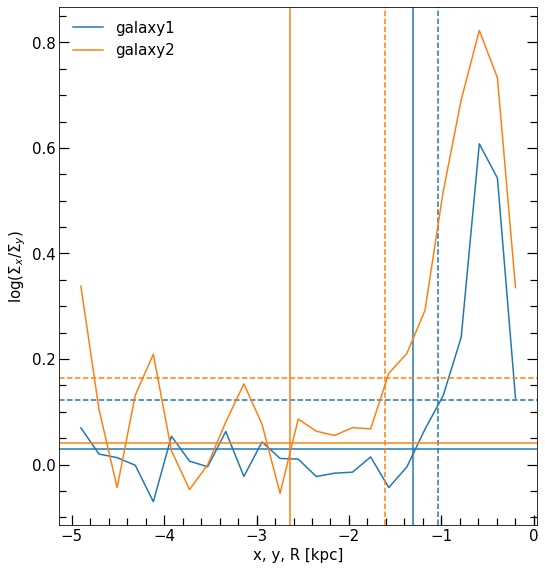

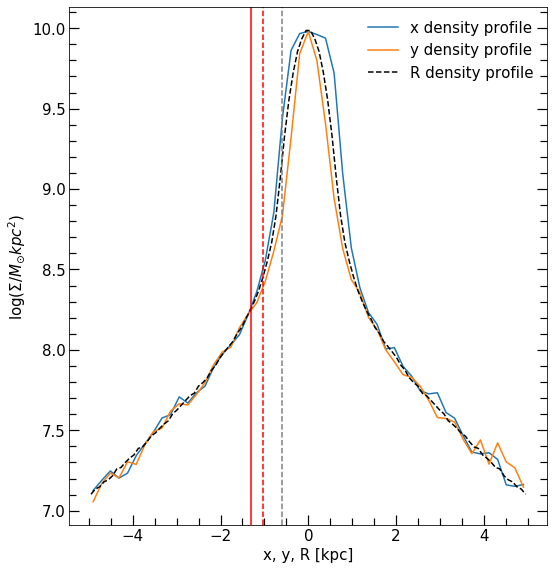

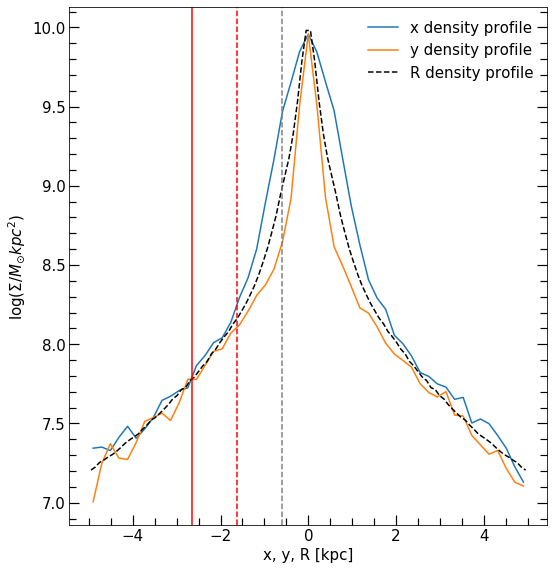

In [102]:
import h5py
import rotation_mio as rot
import time_conversion as tiempo
import barstrength2 as strng
import scipy.interpolate as sint
import numpy as np
import matplotlib.pyplot as plt
import density

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------

path = '/home/ornela/SimCLUES/'
# path = '/mnt/sersic2/omarioni/'

snapshot = np.loadtxt(path + 'Gasoline/snapshots.txt', dtype='string')
snapshot = snapshot[::-1]

colores = ('r','tab:blue','tab:orange','r','tab:green')
figs, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
figs.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)

# for j in range(len(snapshot)-1,32,-1):
j=0

halos = (1,2)

for i in halos:
# i=1
    snap = h5py.File(path + 'Gasoline/outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')

    cm   = snap['subhalo_00'+str('%s'%i)+'/Center'][()]
    r200 = snap['subhalo_00'+str('%s'%i)+'/R200'][()]
    time = snap['subhalo_00'+str('%s'%i)+'/Time'][()]
    h    = snap['subhalo_00'+str('%s'%i)+'/h'][()]
    aexp = snap['subhalo_00'+str('%s'%i)+'/aexp'][()]

    pstr = snap['subhalo_00'+str('%s'%i)+'/Str/Coordinates'][()]
    mstr = snap['subhalo_00'+str('%s'%i)+'/Str/Masses'][()]
    vel  = snap['subhalo_00'+str('%s'%i)+'/Str/Velocities'][()]

    #paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
    #----------------------------------------------------------------------
    r200 = r200*aexp
    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = np.cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

    #Calculo de los radios a 50% y 90% la masa de la galaxia
    #-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

    #-----------------------------------------------------------------------

    #componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

    #velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

        #-----------------------------------------------------------------------------------

        #hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte, = np.where(r < 6.)

    A2max, rmax, phimax, phimed = strng.a2max(mstr[corte], xn[corte], yn[corte], 20)

    xx = xn*np.cos(phimed)  + yn*np.sin(phimed)
    yy = xn*-np.sin(phimed) + yn*np.cos(phimed)
    zz = zn

    R = np.sqrt(xx**2 + yy**2)

    corte, = np.where(r<rgal)

    nbin = 51
    #     x_profile, medx = surf_density_x(xx[corte],yy[corte],mstr[corte]*1e10,51,-5,5)    
    #     y_profile, medy = surf_density_x(yy[corte],xx[corte],mstr[corte]*1e10,51,-5,5)
    R_profile, medR = density.surf_density2(R[corte], mstr[corte],nbin,0,5)

    #     R_profile = (x_profile + y_profile)/2

    sigmax, sigmay, medx, medy = surf_density_x(xx[corte],yy[corte],mstr[corte],nbin,-5,5)

    # print sigmax, sigmay

    #-------lbar---------------------------------------------------------------
    diff = np.log10(sigmax[np.where(medx<0)]) - np.log10(sigmay[np.where(medx<0)])

    # print diff.max(), diff.argmax()
    arg = diff.argmax()
    # print medx[np.where(medx>0)][arg]

    cut = diff.max()*5./100.

    finterp = sint.interp1d(medx[np.where(medx<0)],diff,fill_value="extrapolate")
    point = np.linspace(medx[np.where(medx<0)][diff.argmax()],-5,100)

    resta = finterp(point) - cut
    mask, = np.where(resta < 0.)

    lbar4 = point[mask][0]

    print 'lbar_perf =', lbar4

    cut2 = diff.max()*20./100.

    resta2 = finterp(point) - cut2
    mask2, = np.where(resta2 < 0.)

    lbar6 = point[mask2][0]

    print 'lbar_perf_mod = ', lbar6

    RR  = np.concatenate([-medR[::-1],medR])
    Rpf = np.concatenate([R_profile[::-1],R_profile])
    
#     vector=('M31','MW','..','M33')
#     path2 = '/home/omarioni/Barras_GdGs/Barras_Gd/_data/correcciones/'
#     archivo = np.ndarray
#     np.savetxt(archivo,'')
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    fig.subplots_adjust(bottom=0.06, left =0.1, right = 0.93, top = 0.96, wspace=0., hspace= 0.)
    ax.plot(medx, np.log10(sigmax), '-',color='tab:blue', label='x density profile')    
    ax.plot(medy, np.log10(sigmay), '-',color='tab:orange', label='y density profile')    
    ax.plot(RR, np.log10(Rpf), color='k', ls='--', label='R density profile')
    #     ax.plot(medx, diff)
    ax.axvline(x=lbar4,color='r')
    ax.axvline(x=lbar6,color='r',ls='--')
    ax.axvline(x=medx[np.where(medx<0)][arg], color='gray',ls='--')
    # ax.plot(-medR, np.log10(R_profile),color='k', ls='--')
    ax.minorticks_on()
    ax.tick_params( labelsize=15)
    ax.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
    ax.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
    ax.set_ylabel('log($\Sigma$/$M_{\odot}kpc^2$)',fontsize=15)
    ax.set_xlabel('x, y, R [kpc]',fontsize=15)
    ax.legend(fontsize=15,frameon=False)


    axs.plot(medx[np.where(medx<0)], diff, '-', label='galaxy'+str('%s'%i))
    axs.axvline(x=lbar4,ls='-',color=colores[i])
    axs.axhline(y=cut,ls='-',color=colores[i])
    axs.axvline(x=lbar6,ls='--',color=colores[i])
    axs.axhline(y=cut2,ls='--',color=colores[i])


axs.minorticks_on()
axs.tick_params( labelsize=15)
axs.tick_params('both', length=7, width=1.2,which='minor', direction='in', right=True,top=False)
axs.tick_params('both', length=10, width=1.2,which='major', direction='in', right=True,top=False)
axs.set_ylabel('log($\Sigma_x / \Sigma_y$)',fontsize=15)
axs.set_xlabel('x, y, R [kpc]',fontsize=15)
axs.legend(fontsize=15,frameon=False)

plt.show()